In [1]:
import os

In [2]:
os.listdir('/input0/pascal_2012_seg/test')
test_list=os.listdir('/input0/pascal_2012_seg/test/images')
test_num=len(test_list)
print('一共有%d张测试图片'%test_num)

一共有292张测试图片


In [3]:
test_list[:10]

['2011_000310.jpg',
 '2011_002863.jpg',
 '2011_000291.jpg',
 '2011_001722.jpg',
 '2010_005992.jpg',
 '2011_002322.jpg',
 '2011_003145.jpg',
 '2011_000874.jpg',
 '2010_005582.jpg',
 '2010_004662.jpg']

In [4]:
def crop_and_pad(x,y,target_size=(320,320),seed=1):
    np.random.seed(seed)
    h, w = x.shape[0], x.shape[1]
#     print(h,w)
#     print(target_size[1])
    pad_w = max(target_size[1] - w, 0)
    pad_h = max(target_size[0] - h, 0)
    
    x = np.lib.pad(x, ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2), (0, 0)),
                   'constant', constant_values=0.)
    y = np.lib.pad(y, ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2), (0, 0)),
                   'constant', constant_values=0.)
  

    # h, w = x.shape[0], x.shape[1]
    #裁减
    h, w = x.shape[0], x.shape[1]
    rangeh = (h - target_size[0]) // 2
    rangew = (w - target_size[1]) // 2
#     print(rangeh,rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)

    h_start, h_end = offseth, offseth + target_size[0]
    w_start, w_end = offsetw, offsetw + target_size[1]
    x_img=x[h_start:h_end, w_start:w_end, :]
    
    y_mask=y[h_start:h_end, w_start:w_end, :]
#     im=Image.fromarray(y_mask.astype('uint8'))
    
    return x_img,y_mask

In [5]:
colormap = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
            [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
            [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
            [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
            [0, 192, 0], [128, 192, 0], [0, 64, 128]]

#labelVisualize传递进来的是一个二维的索引数组（针对于只有一张图片的时候），即里面只有数字0～20
import matplotlib.pyplot as plt
def labelVisualize(num_class,color_dict,img):
    #把二维的索引数组根据索引转换为正常的rgb图片
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]

    img_out/=255.

    return img_out

#将21通道的三维数组转化为二维的索引数组
def label2image(label):
    two_array=np.zeros(label[:,:,0].shape)
    idx=np.argwhere(label==1)
    for each in idx:
        two_array[each[0],each[1]]=each[2]

    return two_array

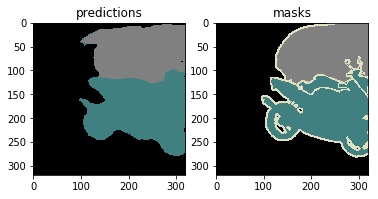

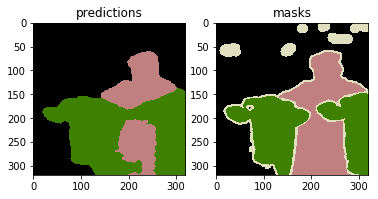

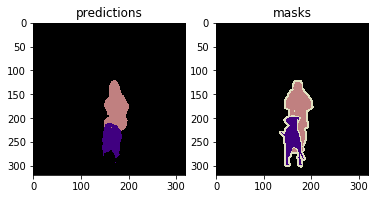

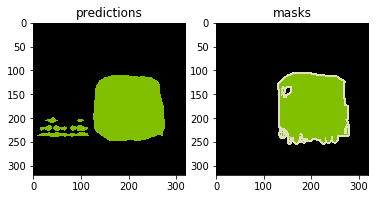

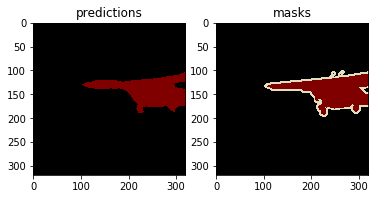

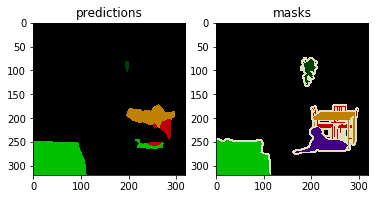

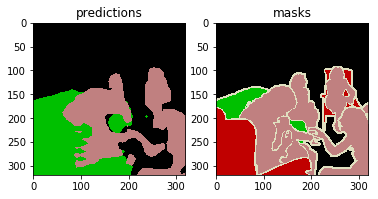

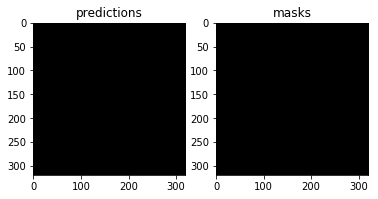

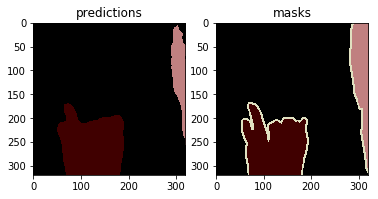

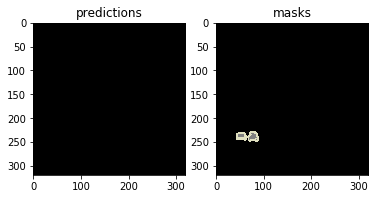

In [8]:
from matplotlib import pyplot as plt
import cv2 # used for resize. if you dont have it, use anything else
import numpy as np
from model import Deeplabv3
from keras.preprocessing import image

deeplab_model = Deeplabv3(input_shape=(320,320,3))
deeplab_model.load_weights('./models/lab_01_deeplab_v3.hdf5')

for each in test_list[10:20]:
    img_name=each.split('.')[0]
    fig=plt.figure()
    x=image.load_img('/input0/pascal_2012_seg/test/images/'+each)
    ori_mask=image.load_img('/input0/pascal_2012_seg/test/masks/'+img_name+'.png')    
    x=image.img_to_array(x)
    x=x/255.
#     print(x.shape)
    x,y=crop_and_pad(x,ori_mask)
#     print(x.shape)
#     plt.imshow(x)
    pre=deeplab_model.predict(np.expand_dims(x,axis=0))
#     print(pre.shape)

    mask = pre.argmax(axis=-1)[...,None] == np.arange(pre.shape[-1])
    out = mask.astype('int')
    
    x=label2image(out[0,:,:,:])
    new_label=labelVisualize(21,colormap,x)
    fig.add_subplot(1,2,1)
    plt.title('predictions')
    plt.imshow(new_label)
    
    
#     ori_mask=image.load_img('/input0/pascal_2012_seg/test/masks/'+img_name+'.png')
    fig.add_subplot(1,2,2)
    plt.title('masks')
    plt.imshow(y)
    